### Imports

In [1]:
import pandas as pd
import nltk, re, string
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn import svm
from sklearn.linear_model import SGDClassifier

from sklearn import linear_model

from sklearn.metrics import confusion_matrix
import sklearn.metrics as metrics
import itertools
%matplotlib inline
import matplotlib.pyplot as plt

In [4]:
df = pd.read_csv("yelp_data_official_training.csv", sep = "|", )
df = df[df["Review Text"].notnull()]


In [21]:
df_pet_vet = df[(df.Category >=5)]
df_pet_vet.apply(np.random.permutation)
df_train = df_pet_vet[:round(0.8*len(df_pet_vet))]
df_test = df_pet_vet[round(0.8*len(df_pet_vet)):]

In [22]:
X_train, X_test = feature_extraction(df_train, df_test)

In [34]:
clf = classify_train("svm_rbf", X_train, df_train.Category)
predictions = classify_predict(clf, X_test)
print(check_val_score(predictions, df_test.Category))
cnf_matrix =confusion_matrix(df_test.Category,predictions)

0.892055267703


In [35]:
cnf_matrix

array([[827,  44],
       [ 81, 206]])

### Preprocess Data

In [36]:
# Reads the csv file and load into dataframe and divides it into training and test set
def read_data(run_type):
    df = pd.read_csv("yelp_data_official_training.csv", sep = "|", )
    df = df[df["Review Text"].notnull()]
    if run_type == "train":
        df.apply(np.random.permutation)
        df_train = df[:round(0.8*len(df))]
        df_test = df[round(0.8*len(df)):]
    else:
        df_train = df
        df_test = pd.read_csv("yelp_data_official_test_nocategories.csv", sep="|")
    return df_train, df_test

### Tokenization

In [13]:
def build_tokens(text):
    tokens = nltk.tokenize.word_tokenize(text)
    tokens = [nltk.WordNetLemmatizer().lemmatize(token) for token in tokens if token.isalpha() and len(token)>3]
    tokens= [nltk.PorterStemmer().stem(token) for token in tokens]
    return tokens

### Feature Extraction

In [14]:
# tfidf feature extraction and chi2 selection
def feature_extraction(df_train, df_test):
    vectorizer = TfidfVectorizer(sublinear_tf=True, max_df=0.5, stop_words='english', ngram_range=(1,2), analyzer= "word", tokenizer= build_tokens ,min_df=10,max_features=4000) #current best for max_features = 4000
    X_train = vectorizer.fit_transform(df_train["Review Text"])
    X_test = vectorizer.transform(df_test["Review Text"])

    ch2 = SelectKBest(chi2, k = 2000) #current best for k=2000
    X_train = ch2.fit_transform(X_train, df_train.Category)
    X_test = ch2.transform(X_test)
    
    ####### Debug run #######
    # feature_names = vectorizer.get_feature_names()
    # feature_names = [feature_names[i] for i in ch2.get_support(indices=True)]
    
    return X_train, X_test

### Classifier

In [33]:
# 
def classify_train(clf_type, X_train, train_category):
    if clf_type == "logreg":
        logreg = linear_model.LogisticRegression(C=0.5e2, max_iter=1000)
        logreg.fit(X_train, train_category)
        return logreg
    elif clf_type == "svm_rbf":
        clf = svm.SVC(kernel='rbf', gamma=0.8, C=1, decision_function_shape="ovr", class_weight='balanced')
        clf.fit(X_train, train_category)
        return clf
    elif clf_type == "svm_linear":
        clf = svm.SVC(kernel = 'linear', probability = True)
        clf.fit(X_train, train_category)
        return clf
    
    elif clf_type == "sgd":
        clf = SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, n_iter=5, random_state=42)
        clf.fit(X_train, train_category)
        return clf
  

        

In [16]:

def classify_predict(clf, X_test):
    predictions = clf.predict(X_test)
    return predictions

def check_val_score(predictions, true_vals):
    return metrics.accuracy_score(true_vals,predictions)

In [41]:

def write_output(predictions):
    output = pd.DataFrame(predictions)
    output.columns = ["Category"]
    output.index.names = ["Id"]
    output.to_csv(path_or_buf="submission.csv", sep=",")

In [42]:

def training_run():
    df_train, df_test = read_data("train")
    X_train, X_test = feature_extraction(df_train, df_test)
    clf = classify_train("sgd", X_train, df_train.Category)

    predictions = classify_predict(clf, X_test)
    print(check_val_score(predictions, df_test.Category))

    
def test_run():
    df_train, df_test = read_data("test")
    X_train,X_test = feature_extraction(df_train, df_test)
    clf = classify_train("sgd", X_train, df_train.Category)

    predictions = classify_predict(clf, X_test)
    write_output(predictions)

In [43]:
training_run()

0.830104166667


In [10]:
test_run()

In [81]:
df_train, df_test = read_data("train")
X_train, X_test = feature_extraction(df_train, df_test)

In [82]:
clf1 = classify_train("logreg", X_train, df_train.Category)
clf2 = classify_train("svm_rbf", X_train, df_train.Category)
clf3 = classify_train("svm_linear", X_train, df_train.Category)

In [83]:
pred1 = classify_predict(clf, X_test)
pred2 = classify_predict(clf2, X_test)
pred3 = classify_predict(clf3, X_test)

In [92]:
# pred_comb = pd.DataFrame()
# pred_comb["clf1"] = pred1
# pred_comb["clf2"] = pred2
# pred_comb["clf3"] = pred3
# predictions = pred_comb.mode(axis=1)

In [99]:
predictions =pred2

In [100]:
print(check_val_score(predictions, df_test.Category))

0.8721875


In [108]:
cnf_matrix =confusion_matrix(df_test.Category,predictions)

In [109]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[3068   28  197   94    1    1]
 [  44 1068   28  179    1   13]
 [  49   23 2095   41    2    0]
 [  74  159   87 1214    2    0]
 [   6    5   53    4  764   17]
 [  13   12    3   10   81  164]]


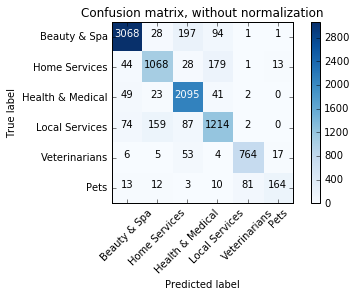

In [115]:
plot_confusion_matrix(cnf_matrix, classes=["Beauty & Spa", "Home Services", "Health & Medical", "Local Services", "Veterinarians", "Pets"], title='Confusion matrix, without normalization')